# [Create Agent with Enterprise File Search](https://learn.microsoft.com/en-us/python/api/overview/azure/ai-projects-readme?view=azure-python-preview#create-agent-with-enterprise-file-search)
We can upload file to Azure as it is shown in this example, or use the existing Azure blob storage.<br/><br/>
**IMPORTANT**: the interactive user must have the `Storage Blob Data Contributor` role on the Azure Storage Account.
<br/><br/>
In the code below, we demonstrate how this can be achieved:
- first, we upload file to azure and create `VectorStoreDataSource`, which then is used to create a `VectorStore`;
- then, this vector store is given to the `FileSearchTool` constructor to creates embeddings for it.

# Constants

In [1]:
import os
from IPython.display import Markdown, display
from dotenv import load_dotenv # requires python-dotenv
from PIL import Image # requires pip install pillow
from datetime import datetime
from common.agents_helper_functions import *
import importlib.metadata
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

if not load_dotenv("./../config/credentials_my.env"):
    print("Environment variables not loaded, cell execution stopped")
    sys.exit()
print("Environment variables have been loaded ;-)")

deployment_name =  os.environ["MODEL_DEPLOYMENT_NAME_MINI"]
api_version = os.environ["OPENAI_API_VERSION"] # at least "2025-03-01-preview"

project_connection_string = os.environ["PROJECT_CONNECTION_STRING"]

print(f'Project Connection String: <...{project_connection_string[-30:]}>')
version = importlib.metadata.version("azure-ai-projects")
print(f"azure-ai-projects library installed version: {version}")

Environment variables have been loaded ;-)
Project Connection String: <...hub01-grp;mmai-swc-hub01-prj01>
azure-ai-projects library installed version: 1.0.0b10


# Create AI Foundry Project Client

In [2]:
from azure.ai.projects import AIProjectClient
from azure.ai.projects.models import (
    FileSearchTool,
)
from azure.identity import DefaultAzureCredential
# The following libraries are needed for Enterprise file search
from azure.ai.projects.models import VectorStoreDataSource, FileSearchTool, VectorStoreDataSourceAssetType

project_client = AIProjectClient.from_connection_string(
    credential=DefaultAzureCredential(), conn_str=project_connection_string
)

project_client.scope

{'subscription_id': 'eca2eddb-0f0c-4351-a634-52751499eeea',
 'resource_group_name': 'mmai-swc-hub01-grp',
 'project_name': 'mmai-swc-hub01-prj01'}

In [3]:
_, asset_uri = project_client.upload_file(file_path="./product_info_1.md")
# asset_uri = "azureml://subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourcegroups/mmai04-rg/workspaces/mmai-hub04-prj01-fvye/datastores/workspaceblobstore/paths/LocalUpload/d6b40c5c4bae2d7022f0fb660f2773d4/product_info_1.md"
print(f"Asset URI: {asset_uri}")

Asset URI: azureml://subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourcegroups/mmai-swc-hub01-grp/workspaces/mmai-swc-hub01-prj01/datastores/workspaceblobstore/paths/LocalUpload/d6b40c5c4bae2d7022f0fb660f2773d4/product_info_1.md


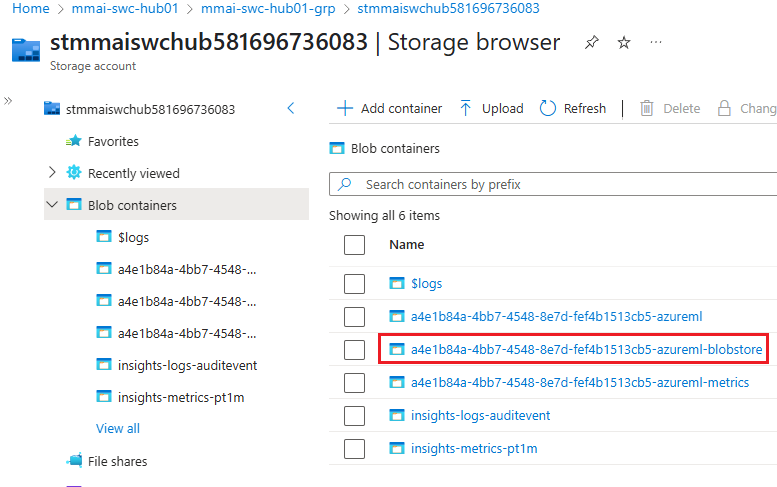
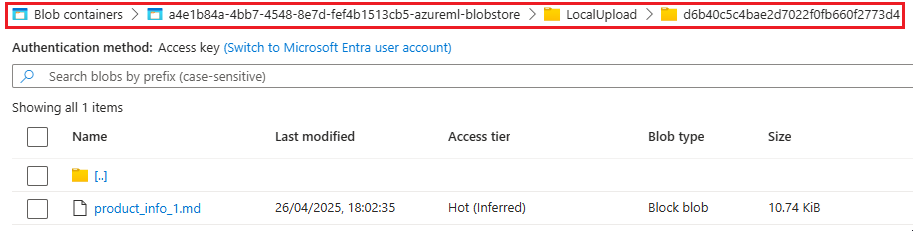

# Create a [vector store data source](https://learn.microsoft.com/en-us/python/api/azure-ai-projects/azure.ai.projects.models.vectorstoredatasource?view=azure-python-preview)

In [4]:
ds = VectorStoreDataSource(asset_identifier=asset_uri, asset_type=VectorStoreDataSourceAssetType.URI_ASSET)
print(f"Created vector store datasource, vector store: {ds}")

Created vector store datasource, vector store: {'uri': 'azureml://subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourcegroups/mmai-swc-hub01-grp/workspaces/mmai-swc-hub01-prj01/datastores/workspaceblobstore/paths/LocalUpload/d6b40c5c4bae2d7022f0fb660f2773d4/product_info_1.md', 'type': 'uri_asset'}


# Create a [vector store and poll](https://learn.microsoft.com/en-us/python/api/azure-ai-projects/azure.ai.projects.operations.agentsoperations?view=azure-python-preview#azure-ai-projects-operations-agentsoperations-create-vector-store-and-poll)

In [5]:
# Check if we have any files already on Azure AI Foundry
# If needed, we may delete them using the cells at the bottom of this notebook

print(f"({len(project_client.agents.list_files()['data'])}) Files on AI Foundry (should be empty): {project_client.agents.list_files()['data']}")

(0) Files on AI Foundry (should be empty): []


In [6]:
# Create the vector store
vector_store = project_client.agents.create_vector_store_and_poll(data_sources=[ds], name="sample_vector_store")
print(f"Created vector store, vector store: {vector_store}\n")

# Check if we have any files already on Azure AI Foundry, again
# If needed, we may delete them using the cells at the bottom of this notebook
print(f"({len(project_client.agents.list_files()['data'])}) Files on AI Foundry (should be one): {project_client.agents.list_files()['data']}")

store_configuration: {'data_sources': [{'uri': 'azureml://subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourcegroups/mmai04-rg/workspaces/mmai-hub04-prj01-fvye/datastores/workspaceblobstore/paths/LocalUpload/d6b40c5c4bae2d7022f0fb660f2773d4/product_info_1.md', 'type': 'uri_asset'}]}
Created vector store, vector store: {'id': 'vs_BwdpM2IkCeit4N954s6JSGmO', 'object': 'vector_store', 'name': 'sample_vector_store', 'status': 'completed', 'usage_bytes': 17143, 'created_at': 1745708531, 'file_counts': {'in_progress': 0, 'completed': 1, 'failed': 0, 'cancelled': 0, 'total': 1}, 'metadata': {}, 'expires_after': None, 'expires_at': None, 'last_active_at': 1745708531}

(1) Files on AI Foundry (should be one): [{'object': 'file', 'id': 'assistant-2LN26z3jetnBkkevraMsMe', 'purpose': 'assistants', 'filename': 'azureml://subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourcegroups/mmai04-rg/workspaces/mmai-hub04-prj01-fvye/datastores/workspaceblobstore/paths/LocalUpload/d6b40c5c4bae2d702

# Create a file search tool

In [7]:
file_search_tool = FileSearchTool(vector_store_ids=[vector_store.id])

print(f"file_search_tool.definitions: {file_search_tool.definitions}")
print(f"file_search_tool.resources: {file_search_tool.resources}")

file_search_tool.definitions: [{'type': 'file_search'}]
file_search_tool.resources: {'file_search': {'vector_store_ids': ['vs_BwdpM2IkCeit4N954s6JSGmO']}}


# Create AI Foundry Agent

In [8]:
# Agent creation
# Notices that FileSearchTool as tool and tool_resources must be added or the assistant unable to search the file
agent = project_client.agents.create_agent(
    model=deployment_name,
    name="enterprisefilesearch-agent",
    instructions="You are helpful agent",
    tools=file_search_tool.definitions,
    tool_resources=file_search_tool.resources
)
print(f"Created agent, ID: {agent.id}")

Created agent, ID: asst_ylgLz8w0Z6O4dNnY6ZvWeS7M


# Create the thread and attach a new message to it

In [9]:
# Create a thread
thread = project_client.agents.create_thread()
print(f"Created thread: {thread}\n")

# Add a user message to the thread
message = project_client.agents.create_message(
    thread_id=thread.id, 
    role="user", 
    content="Hello, how much for the TrailMaster?",
)
print(f"Created message: {message}")

Created thread: {'id': 'thread_qNZffu9qA8QiwZMlFmdKjT1I', 'object': 'thread', 'created_at': 1745708544, 'metadata': {}, 'tool_resources': {}}

Created message: {'id': 'msg_aBvikFbwhERsORsA4Akxwjju', 'object': 'thread.message', 'created_at': 1745708545, 'assistant_id': None, 'thread_id': 'thread_qNZffu9qA8QiwZMlFmdKjT1I', 'run_id': None, 'role': 'user', 'content': [{'type': 'text', 'text': {'value': 'Hello, how much for the TrailMaster?', 'annotations': []}}], 'attachments': [], 'metadata': {}}


# Run the agent syncrhonously

In [10]:
%%time
# Create and process assistant run in thread with tools
run = project_client.agents.create_and_process_run\
    (thread_id=thread.id, agent_id=agent.id)

print(f"Run finished with status: {run.status}.\n\nRun: {run}")

if run.status == "failed":
    # Check if you got "Rate limit is exceeded.", then you want to get more quota
    print(f"Run failed: {run.last_error}")

Run finished with status: RunStatus.COMPLETED.

Run: {'id': 'run_Y5SGqOyt6JXSOr3iqITpcfiO', 'object': 'thread.run', 'created_at': 1745708546, 'assistant_id': 'asst_ylgLz8w0Z6O4dNnY6ZvWeS7M', 'thread_id': 'thread_qNZffu9qA8QiwZMlFmdKjT1I', 'status': 'completed', 'started_at': 1745708546, 'expires_at': None, 'cancelled_at': None, 'failed_at': None, 'completed_at': 1745708549, 'required_action': None, 'last_error': None, 'model': 'gpt-4o', 'instructions': 'You are helpful agent', 'tools': [{'type': 'file_search'}], 'tool_resources': {}, 'metadata': {}, 'temperature': 1.0, 'top_p': 1.0, 'max_completion_tokens': None, 'max_prompt_tokens': None, 'truncation_strategy': {'type': 'auto', 'last_messages': None}, 'incomplete_details': None, 'usage': {'prompt_tokens': 6294, 'completion_tokens': 36, 'total_tokens': 6330, 'prompt_token_details': {'cached_tokens': 0}}, 'response_format': 'auto', 'tool_choice': 'auto', 'parallel_tool_calls': True}
CPU times: total: 46.9 ms
Wall time: 5.57 s


# Fetch messages from the thread after the agent run execution

In [11]:
from azure.ai.projects.models import MessageTextContent, MessageImageFileContent

if run.status == 'completed':    
    messages = project_client.agents.list_messages(thread_id=thread.id)
    messages_nr = len(messages.data)
    print(f"Here are the {messages_nr} messages:\n")
    
    for i, message in enumerate(reversed(messages.data), 1):
        j = 0
        print(f"\n===== MESSAGE {i} =====")
        for c in message.content:
            j +=1
            if (type(c) is MessageImageFileContent):
                print(f"\nCONTENT {j} (MessageImageFileContent) --> image_file id: {c.image_file.file_id}")
            elif (type(c) is MessageTextContent):
                print(f"\nCONTENT {j} (MessageTextContent) --> Text: {c.text.value}")
                for a in c.text.annotations:
                    print(f">>> Annotation in MessageTextContent {j} of message {i}: {a.text}\n")

else:
    print(f"Sorry, I can't proceed because the run status is {run.status}")

Here are the 2 messages:


===== MESSAGE 1 =====

CONTENT 1 (MessageTextContent) --> Text: Hello, how much for the TrailMaster?

===== MESSAGE 2 =====

CONTENT 1 (MessageTextContent) --> Text: The price of the TrailMaster X4 Tent is $250【4:0†source】.
>>> Annotation in MessageTextContent 1 of message 2: 【4:0†source】



## Fetch citations from the messages

In [12]:
# messages.file_path_annotations[0].text.split('/')[-1]
print (f"Nr. of file path citations: {len(messages.file_citation_annotations)}\n")

i=0
for file_citation_annotation in messages.file_citation_annotations:
    i += 1
    print(f"{i} - File file_citation_annotation: {file_citation_annotation}")

Nr. of file path citations: 1

1 - File file_citation_annotation: {'type': 'file_citation', 'text': '【4:0†source】', 'start_index': 44, 'end_index': 56, 'file_citation': {'file_id': 'assistant-2LN26z3jetnBkkevraMsMe'}}


# Retrieve and download eventual images

In [13]:
# messages.file_path_annotations[0].text.split('/')[-1]
print (f"Nr. of file path annotations: {len(messages.file_path_annotations)}\n")

i=0
for file_path_annotation in messages.file_path_annotations:
    i += 1
    print(f"{i} - File annotation paths: {file_path_annotation}")
    file_name = file_path_annotation.text.split('/')[-1]
    project_client.agents.save_file(file_id=file_path_annotation.file_path.file_id, file_name=file_name)
    print(f"File annotation {i} saved as file to: {os.getcwd()}\\{file_name}")
    image = Image.open(f"{os.getcwd()}\\{file_name}") # Open the image
    image.show() # Display the image

Nr. of file path annotations: 0



# Collect all resources for this project

In [14]:
all_agents = list_all_agents(project_client=project_client)
print(all_agents["summary"])

all_threads = list_all_threads(project_client)
print(all_threads["summary"])

all_files = list_all_files(project_client)
print(all_files["summary"])

all_runs = list_all_runs(project_client)
print(all_runs["summary"])

all_runsteps=list_all_runsteps(project_client)
print(all_runsteps["summary"])

all_messages = list_all_messages(project_client)
print(all_messages["summary"])

all_vectorstores = list_all_vectorstores(project_client=project_client)
print(all_vectorstores["summary"])

1 agents in project <mmai-hub04-prj01-fvye>
1 threads in project <mmai-hub04-prj01-fvye>
1 files in project <mmai-hub04-prj01-fvye>
1 runs in 1 threads of project <mmai-hub04-prj01-fvye>
2 run steps in 1 pairs of (thread, run) of project <mmai-hub04-prj01-fvye>
2 messages in 1 threads of project <mmai-hub04-prj01-fvye>
1 vector stores in project <mmai-hub04-prj01-fvye>


# Teardown for all resources

In [15]:
# delete all vector stores

i=0
for vector_store in all_vectorstores["content"]["data"]:
    i += 1
    project_client.agents.delete_vector_store(vector_store_id=vector_store.id)
    print(f"{i} - Vector store <{vector_store.id}> has been deleted")

all_vectorstores = list_all_vectorstores(project_client=project_client)

print(f"Vector stores deleted: {i}\n")

1 - Vector store <vs_BwdpM2IkCeit4N954s6JSGmO> has been deleted
Vector stores deleted: 1



In [16]:
# delete all files

i=0
for file in all_files['content']['data']:
    i += 1
    project_client.agents.delete_file(file_id=file.id)
    print(f"{i} - File <{file.filename}> ({file.id}) has been deleted")

all_files = list_all_files(project_client)

print(f"Files deleted: {i}\n")

1 - File <azureml://subscriptions/eca2eddb-0f0c-4351-a634-52751499eeea/resourcegroups/mmai04-rg/workspaces/mmai-hub04-prj01-fvye/datastores/workspaceblobstore/paths/LocalUpload/d6b40c5c4bae2d7022f0fb660f2773d4/product_info_1.md> (assistant-2LN26z3jetnBkkevraMsMe) has been deleted
Files deleted: 1



In [17]:
# delete all threads

i=0
for thread in all_threads["content"]["data"]:
    i += 1
    project_client.agents.delete_thread(thread_id=thread.id)
    print(f"{i} - Thread <{thread.id}> has been deleted")

all_threads = list_all_threads(project_client)

print(f"Threads deleted: {i}\n")

1 - Thread <thread_qNZffu9qA8QiwZMlFmdKjT1I> has been deleted
Threads deleted: 1



In [18]:
# delete all agents

i=0
for agent in all_agents["content"]["data"]:
    i += 1
    project_client.agents.delete_agent(agent_id=agent.id)
    print(f"{i} - Agent <{agent.id}> has been deleted")

all_agents = list_all_agents(project_client=project_client)

print(f"Agents deleted: {i}\n")

1 - Agent <asst_ylgLz8w0Z6O4dNnY6ZvWeS7M> has been deleted
Agents deleted: 1



# HIC SUNT LEONES